In [1]:
import sys
sys.path.append(r'C:\AppSource\TrajectoryArt\build\bin')

In [2]:
from PyTrajectoryArt import Trajectory

In [3]:
%matplotlib inline

traj.GetDuration()= 16.9372s


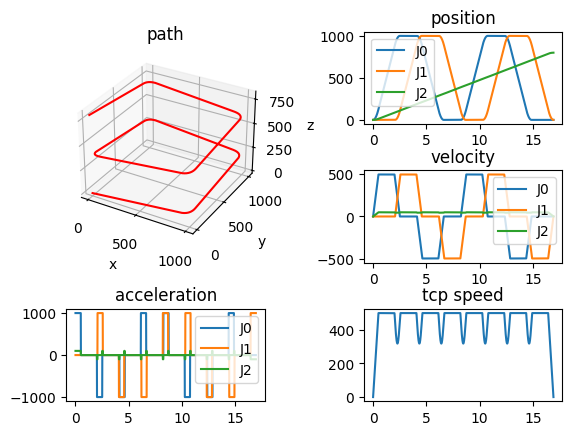

<Figure size 640x480 with 0 Axes>

In [4]:
%run C:\AppSource\TrajectoryArt\Example\UseTrajectoryArt.py

In [5]:
waypoints

array([[   0.,    0.,    0.],
       [1000.,    0.,  100.],
       [1000., 1000.,  200.],
       [   0., 1000.,  300.],
       [   0.,    0.,  400.],
       [1000.,    0.,  500.],
       [1000., 1000.,  600.],
       [   0., 1000.,  700.],
       [   0.,    0.,  800.]])

# TrajectoryArt的用法

## 简介

TrajectoryArt（以下简称TA）可以根据用户输入的一系列关节空间（joint space）或者笛卡尔空间（工作工件, cartesian space, task sapce）的路径点（waypoint），以及轨迹的速度约束、加速度约束等计算一条时间最优轨迹。

## 基本概念
### 轨迹的计算过程及表示

TA中计算一条轨迹，大致的步骤如下：

- 进行路径（Path）的光滑插值，获取到至少满足C1（一阶导数，即切向，Tangent）连续的路径 $p(s)$ ，`s` 是路径的参数，一般的意义是弧长。插值算法一般有：
    - 三次样条曲线、贝塞尔曲线等拟合插值
    - 直线加弧线过渡，TA里面弧线可以设置为二阶、五阶贝塞尔，或者圆弧
- 计算参数曲线 $s(t)$ ，`t` 为时间。 $p(s)$ 表示的是轨迹在空间中的位置路径，$s(t)$ 表示的是轨迹沿这条路径前进的快慢，拥有了时间属性，继而可以计算速度、加速度
- 最终轨迹的表达式为 $q(t) = p(s(t))$ ，在物理意义上，`t` 表示时间，`s` 可以理解为从轨迹起点到当前时间点沿着轨迹路径走过的曲线长度

### 轨迹的速度、加速度约束

以机器人关节空间为例，每个关节能够运行的最大速度、最大加速度是由电机功率决定的，因此决定了关节运行速度、加速度的会有一个最大值。

在TA中进行计算的时候，计算时间最优轨迹，需要添加以下约束：

$$
\dot q_{min} \le \dot q \le \dot q_{max}
$$
$$
\ddot q_{min} \le \ddot q \le \ddot q_{max}
$$


## TA的使用方法

TA使用统一的接口 `traj = Trajectory.Create(waypoints, params)` 进行计算，其中 `waypoints` 就是所有路径点，`params` 是与算法相关的其他参数。

返回值 `traj` 是一个 `Trajectory` 对象，我们可以使用下面的接口获取到轨迹的相关信息：

- `GetDuration`： 获取轨迹时长
- `GetPosition(t)`：获取`t`时刻的轨迹位置
- `GetVelocity(t)`：获取`t`时刻的轨迹速度
- `GetAcceleration(t)`：获取`t`时刻的轨迹加速度

下面就不同的算法对`params`参数进行解释。

### 梯形速度算法

梯形速度算法使用直线段-贝塞尔二阶的路径插值算法，因为在直线段使用梯形速度曲线，由此得名。

梯形速度算法可设置的参数如下：

- `algorithm`: 需要设置为 `trapezoidal`，或者不设置也可以，默认即是该值
- `path_type`: 设置为 `bezier_quadratic_blend`, 可以不设置，默认就是 `bezier_quadratic_blend`
- `tolerance_blend`: 过渡段贝塞尔曲线的长度与该值正相关
- `vel_limits`: 设置各个关节的最大速度；可以是单个实数或者一个列表，如果是单个实数，那么所有关节的最大速度都是该值
- `acc_limits`: 设置各个关节的最大加速度，同样的可以是单个值或者一个列表

具体参考如下例子：

In [7]:
params = {}
params["algorithm"] = "trapezoidal" 
params["path_type"] = "bezier_quadratic_blend" 
params["tolerance_blend"] = 100.0 
params["vel_limits"] = [500.0] * 3
params["acc_limits"] = [3000.0] * 3
traj = Trajectory.Create(waypoints, params)
print(traj.GetDuration())

16.166666666666668


以上就成功创建了一条轨迹，我们将它显示出来：

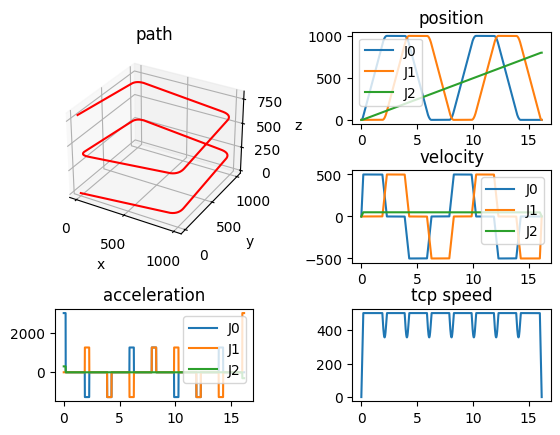

In [8]:
plot_traj_components(traj)

该算法的计算速度很快，我们可以大致测试一下在通过python封装的速度。

In [9]:
%%timeit 
traj = Trajectory.Create(waypoints, params)

440 μs ± 39.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 梯形匀速算法

梯形速度算法是给定速度、加速度限制的时间最优轨迹，但是从结果图中也可以看出，该方法计算出来的机器人工具末端点速度（tcp speed，各个自由度的速度的合成速度）有反复波动，有些情况下我们需要计算一条刀具点速度恒定不变的轨迹，梯形匀速算法用来生成这种轨迹。

它需要设置的参数如下：

- `algorithm`：设置为 `trapezoidal_constant_speed`
- `path_type`: 推荐设置为 `circle_blend`，此时严格匀速；如果设置为 `bezier_quadratic_blend` 或者 `bezier_quintic_blend` 可以接近于匀速
- `tolerance_blend`: 与之前相同，控制弧线段长度
- `speed`: 刀具点的匀速速度
- `acceleration`：刀具点的加速度

参考如下例子：

In [10]:
params = {}
params["algorithm"] = "trapezoidal_constant_speed" 
params["path_type"] = "circle_blend" 
params["tolerance_blend"] = 100.0 
params["speed"] = 300.0
params["acceleration"] = 1000.0
traj = Trajectory.Create(waypoints, params)

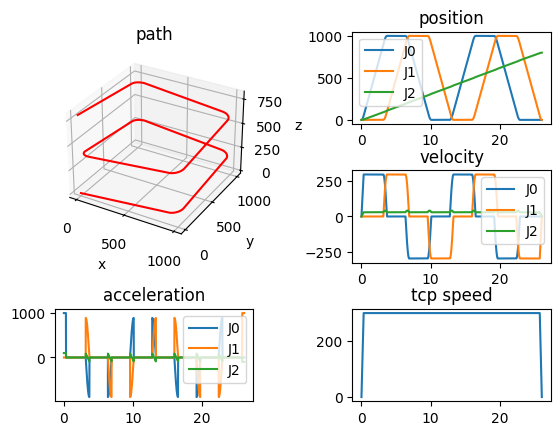

In [11]:
plot_traj_components(traj)

从右下角图中可以看出，轨迹的刀具点速度是恒定不变的。但需要注意的是，该算法并不考虑各个自由度单独的速度、加速度限制，计算出来的轨迹可能导致某个自由度的速度、加速度超限。一般来讲，各个自由度的最大速度不会超过给定的最大匀速速度（只有单个自由度运动时，刀具点速度就是该自由度的速度）；但是各自由度的加速度在弧线段可能具有很大的值。

比如我们将`speed`设置为500.0，重新计算，可以看到轨迹时间缩短，但是最大加速度也显著增加。使用该算法时，需要认真考虑是否会导致某个自由度的加速度超限。

In [12]:
params["speed"] = 500.0
traj = Trajectory.Create(waypoints, params)

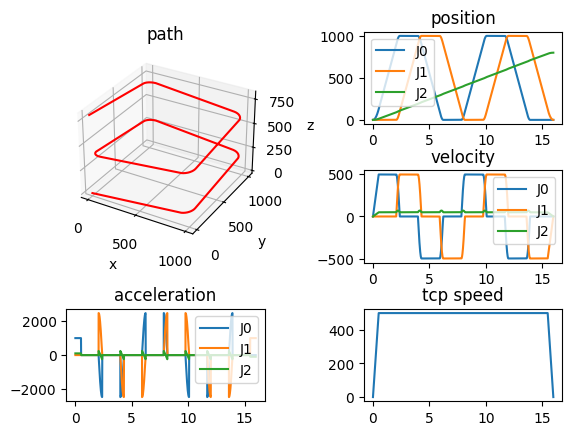

In [13]:
plot_traj_components(traj)

### TOPPRA 时间最优算法

该算法可以针对任意C1连续的轨迹，计算出时间最优的参数 $s(t)$ ，相对于梯形速度算法，同等约束和路径下计算出来的轨迹时长一般会更短，但是计算量相对更大，计算耗时也稍微长一些。

在计算时，TOPPRA算法以一定的**步长**在路径上采样点，计算每个点处在给定约束下可以采取的最大速度，最终生成的轨迹就是沿着给定路最开到达终点的。

它需要设置的参数如下：

- `algorithm`: 设置为 `toppra`
- `path_type`: 推荐设置为 `bezier_quadratic_blend`，也可以设置为 `bezier_quintic_blend` 或者 `circle_blend`
- `tolerance_blend`: 同上，控制过渡弧长段长度
- `vel_limits`: 同上，各个自由度的速度约束
- `acc_limits`: 同上，各个自由度的加速度约束
- `step_size`: 上文所属的**步长**，设置的越小，计算越耗时，一般可以设置为希望轨迹保持的精度，比如 `0.1 mm`

参考例子如下：

In [14]:
params = {}
params["algorithm"] = "toppra" 
params["path_type"] = "bezier_quadratic_blend" 
params["tolerance_blend"] = 100.0 
params["vel_limits"] = [500.0] * 3
params["acc_limits"] = [3000.0] * 3
params["step_size"] = 0.1
traj = Trajectory.Create(waypoints, params)
print(traj.GetDuration())

15.566076654410695


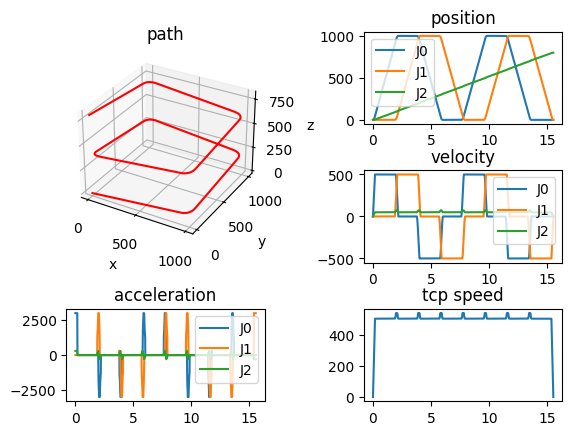

In [15]:
plot_traj_components(traj)

In [16]:
%%timeit
traj = Trajectory.Create(waypoints, params)

2.09 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


可以看到，toppra 算法计算出来的轨迹时间相比梯形速度算法要稍微短一些，但是它的计算耗时远远超过梯形速度算法，不过也可以通过调整`step_size`来减少计算耗时。

### 时间最优的匀速算法

我们之前已经解释了[梯形匀速算法](#梯形匀速算法)，配合圆弧过度，它可以计算刀具点速度严格相等的轨迹，但是并不考虑各个自由度的速度、加速度限制，可能会导致轨迹实际不可执行。时间最优匀速算法，同时考虑刀具点的速度值和各个自由度的速度、加速度限制；在计算时，先根据给定各个自由度速度、加速度的约束计算刀具点此刻能够达到的最大速度，然后实际轨迹的刀具点速度取该值和设置的刀具点速度值中较小的那个。更直白的讲，就是在满足每个自由度速度、加速度约束下，再尽量去满足刀具点的合成速度的约束。

该算法设置的参数与 [TOPPRA 时间最优算法](#TOPPRA时间最优算法)基本一致，只是多了如下参数：

- `speed`: 设置期望的刀具点速度大小，该速度是各个自由度的速度的合成

参考例子如下：

In [17]:
params = {}
params["algorithm"] = "toppra" 
params["path_type"] = "bezier_quadratic_blend" 
params["tolerance_blend"] = 100.0 
params["vel_limits"] = [500.0] * 3
params["acc_limits"] = [3000.0] * 3
params["step_size"] = 0.1
params["speed"] = 500.0
traj = Trajectory.Create(waypoints, params)
print(traj.GetDuration())

15.724171391457714


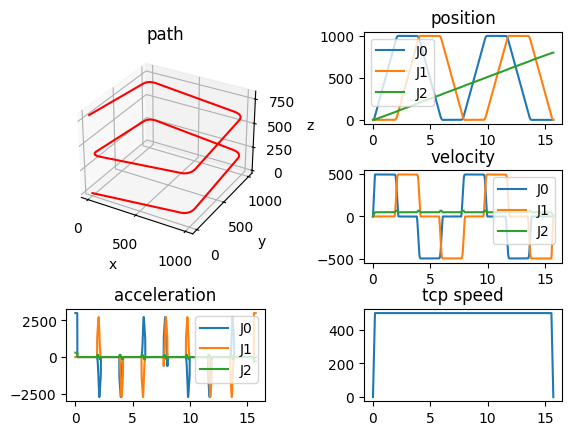

In [18]:
plot_traj_components(traj)

从右下角图中可以看到刀具点速度不再有之前那样的波动，超过500的值都会被截断，轨迹的速度因而更加平滑。

## 总结

在多种轨迹算法之中，我们需要根据应用情况具体来选择一种合适的，我们推荐如下几种使用场景：

- 点对点轨迹，比如抓取放置，对中间路径基本不做要求，或者中间添加几个引导点即可，如果要求计算时间很快，就使用梯形速度算法，如果计算时间没有严格要求，可以使用TOPPRA时间最优算法
- 焊接等要严格跟踪一个路径，以及要求刀具点匀速，这个时候如果刀具点速度不大，且路径比较近似直线，采用梯形匀速算法，一般不会超限；否则使用时间最优的匀速算法
- 大量密集的点构成的很长的路径，这种情况下使用梯形速度算法，以免计算时间太长；如果使用TOPPRA算法，应该用较大一点的步长，根据经验，在c++中，总的采样点数控制在10000000，一般可以在1s内完成计算

以上算法都有一个特点，就是轨迹的速度是连续的，加速度最大/最小值受到约束，但是加速度在最大值/最小值之间直接阶跃，导致轨迹的光滑度没有那么理想，后面我们会实现加速度连续的轨迹算法。